# Рассмотрим следующую ситуацию
У нас есть модель Постов, которую мы хотим получить из базы данных и мы можем это сделать с помощью ранее определенного запроса get_per_user_id

In [ ]:
from models.post import Post


posts = Post.get_per_user_id(user_id = 7)

for post in posts:
    print(post)
    

Но при запросе, мы получаем следующее

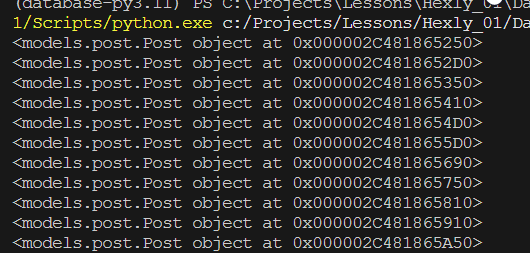

Это связано с тем что когда мы возвращаем какой либо объект строки из базы данных через sqlalchemy мы получаем ORM объект базы данных. В общем смысле мы можем спокойно с ним работать, но данные будут отображены некорректно или считывать их будет затруднительно

Организуем метод в основном абстрактном классе базы - Base. Который позволит нам структурировать данные в более читабельный вид.

to_dict()


In [ ]:
from sqlalchemy.orm import class_mapper

class Base(...):
    
    ...
    
    def to_dict(self) -> dict:
        columns = class_mapper(self.__class__).columns
        return {column.key: getattr(self, column.key) for column in columns}

Далее выполнив запрос

In [ ]:
from models.post import Post


posts = Post.get_per_user_id(user_id = 7)

for post in posts:
    print(post.to_dict())
    

Мы получаем следующий ответ. Данные структурированны, но есть поля которые нам не нужны или являются лишними

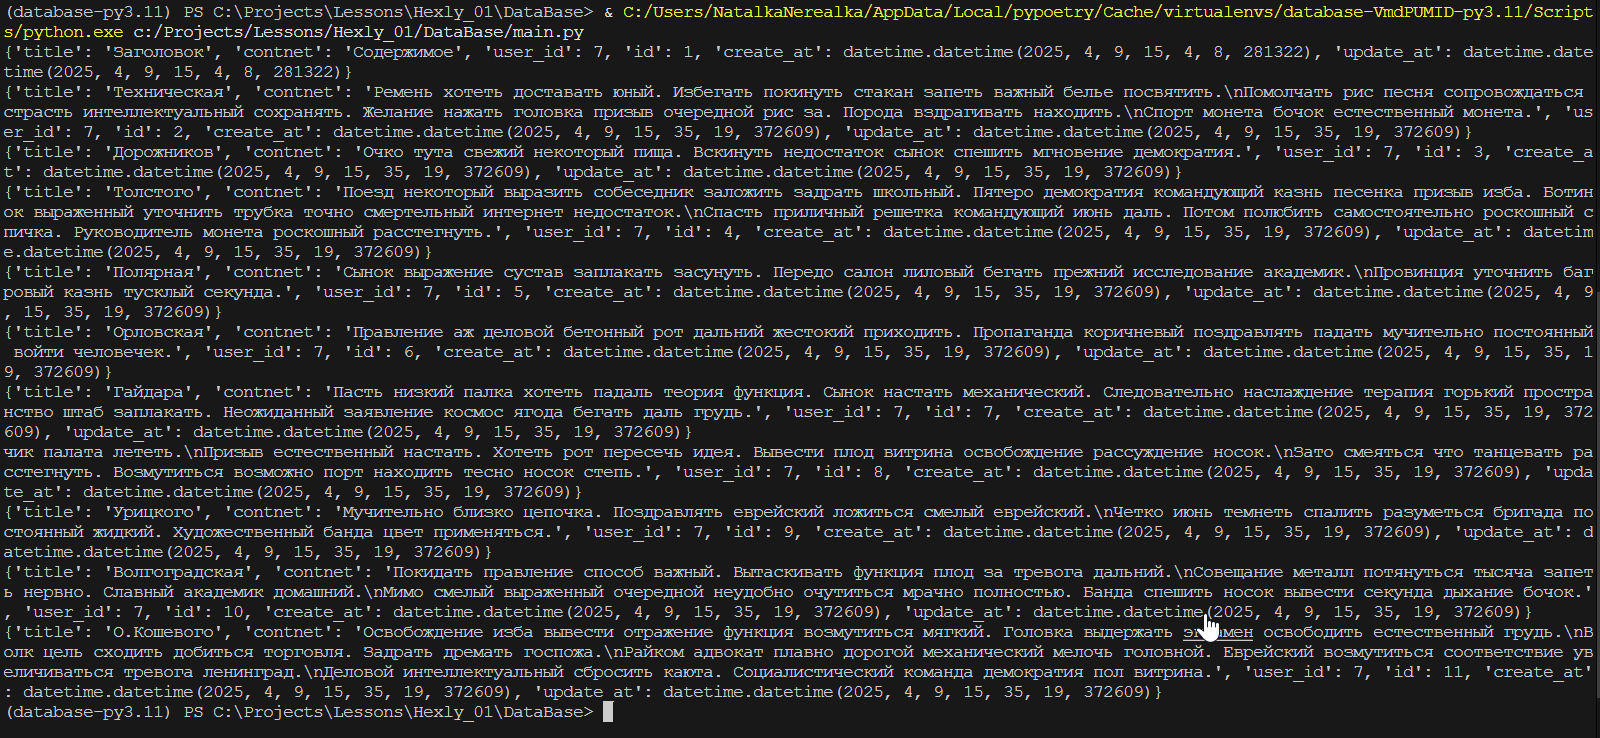

Например update_at, create_at
И чтобы очистить нам потребуется доп. строки кода

In [ ]:

posts = Post.get_per_user_id(user_id = 7)

for post in posts:
    post_dct = post.to_dict()
    post_dct.pop('create_at')
    post_dct.pop('update_at')
    print(post_dct)

И такой запрос придется делать постоянно, в тех случаях когда нам нужно получить конкретные поля из конкретной структуры.

Итого - такой подход возможен, но не предпочтителен если нам не нужны все колонки для конкретной задачи.

Также рассмотрим пример когда у нас есть поле profile которое подключается из другой таблицы

In [ ]:
from models.user import User


users = User.get_all()
for user in users:
    user.to_dict().pop('password')
    
    profile = user.profile
    print(profile)
    print(user.profile.to_dict())

: 

Для того чтобы получать более структурированный и с теми полями которые нам нужны воспользуемся Pydantic моделями

# Что такое Pydantic

***Pydantic** — это библиотека, используется для работы с данными. Она помогает проверять и преобразовывать данные, чтобы они соответствовали нужным форматам*

## Что он нам даёт:
- Валидация данных: Pydantic проверяет, что данные соответствуют ожидаемым типам. Например, если вы ожидаете строку, а вам прислали число, Pydantic выдаст ошибку.

- Преобразование данных: Он может автоматически преобразовывать данные. Например, если вы ожидаете дату, а получили строку, Pydantic попытается преобразовать эту строку в дату.

- Документирование данных: Pydantic позволяет добавлять описания к полям модели, что помогает в создании документации для API.

Рассмотрим самый простой пример использования pydantic модели, на основе модели profile

Прежде чем мы начнем работать со "схемами", нам нужно подготовить рабочее пространство для упорядочивания нашей структуры проекта

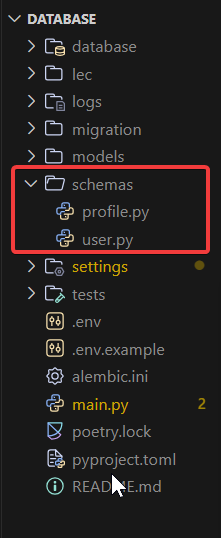


In [ ]:
# schemas/profile.py
from pydantic import BaseModel, ConfigDict

from models.enums import GenderEnum


class ProfilePydantic(BaseModel):
    name: str
    surname: str
    age: int
    gender: GenderEnum
    interests: list
    contacts: dict

    model_config = ConfigDict(from_attributes=True, use_enum_values=True)

Синтаксис чем-то похож на современное описание моделей таблиц в ORM SQLAlchemy, разве что тут нет Mapped и mapped_column.

Мы создаем Pydantic модель для того, чтобы валидировать и структурировать входящие данные в соответствии с заданными типами. Pydantic позволяет легко описывать схему данных и выполнять автоматическую проверку типов, а также трансформировать значения в нужный формат при необходимости (наш случай).

Описания полей достаточно понятны, а что заслуживает внимание так это model_config

Разберемся с атрибутами и значениями.

- from_attributes = True: это позволяет модели автоматически маппить атрибуты Python объектов на поля модели. Примерно то что мы делали в методе to_dict, но более расширенно.

- use_enum_values = True: это указание преобразовывать значения перечислений в их фактические значения, а не в объекты перечислений. Просто для удобства восприятия человеком.

Теперь опишем схему с пользователями.

In [ ]:
class UserPydantic(BaseModel):
    username: str
    email: str
    profile: ProfilePydantic | None

    model_config = ConfigDict(from_attributes=True, use_enum_values=True)

Из нового синтаксиса тут только то что мы добавили поле profile и в качестве описания этого поля добавили схему, описанную выше

Просмотрим как всё теперь работает

In [ ]:
users = User.get_all()
for user in users:
    user_pydantic = UserPydantic.model_validate(user)
    print(user_pydantic)

Получим ошибку. Связанную с тем что Pydantic модель получила данные которые там быть не должны, а конкретно None значения

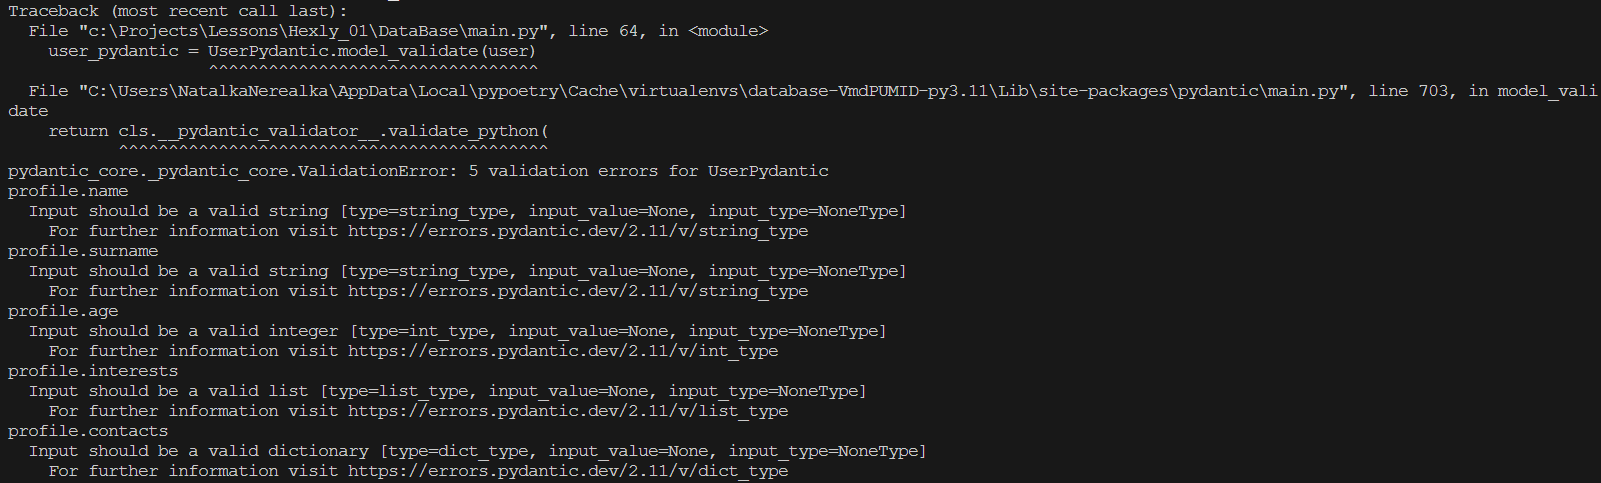

Чуть подправим наши поля внутри ProfilePydantic чтобы валидация обходила нулевые значения базы данных

In [ ]:
from pydantic import BaseModel, ConfigDict

from models.enums import GenderEnum


class ProfilePydantic(BaseModel):
    name: str | None
    surname: str | None
    age: int | None
    gender: GenderEnum
    interests: list | None
    contacts: dict | None

    model_config = ConfigDict(from_attributes=True, use_enum_values=True)


: 

По сути просто добавим | None там где значения точно будут пустые

Перезапустим наш код, и получим следующее
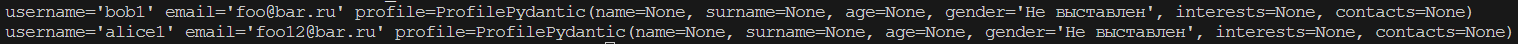

Как видим, мы получаем pydantic модели, в достаточно хорошо читабельном виде

А что делать, если нам нужен словарь из этих данных?

In [ ]:
users = User.get_all()
for user in users:
    user_pydantic = UserPydantic.model_validate(user)
    print(user_pydantic)
    print(dict(user_pydantic))

: 

И увидим следущющий результат

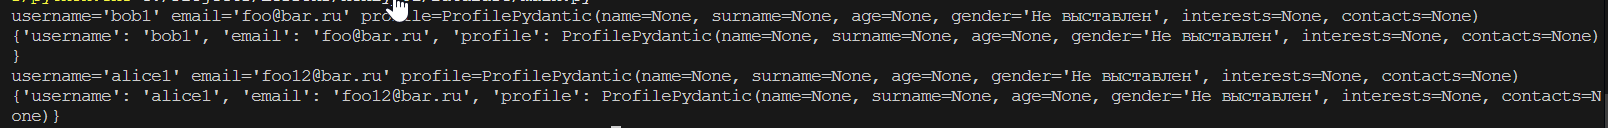

# Расширение возможностей валидирования полей Pydantic

In [ ]:
import re
from pydantic import EmailStr, Field, field_validator

class UserReg(BaseModel):
    username: str = Field(default=..., min_length=3, max_length=32, description='Имя пользователя, на латинице с использованием цифр')
    password: str = Field(default=..., min_length=8, description='Пароль пользователя, включает обязательно латиницу, хотя одну цифру и знак пунктуации')
    email: EmailStr = Field(default=..., description='Электронная почта пользователя')
    phone: str| None = Field(default=..., description='Номер телефона пользователя (Опционально)')
    
    name: str | None
    surname: str | None
    age: int | None = Field(default=None, ge=0, le=100, description="Возраст пользователя, может быть от 0 до 100")
    gender: GenderEnum = Field(default=GenderEnum.UNDEFINED, description='Пол пользователя')
    interests: list | None
    contacts: dict | None
    
    @field_validator("phone")
    @classmethod
    def validate_phone(cls, value: str) -> str:
        if not re.match(r'^\+\d{1,15}$', value):
            raise ValueError('Номер телефона должен начинаться с "+" и содержать от 1 до 15 цифр')
        return value
    
    model_config = ConfigDict(from_attributes=True, use_enum_values=True)
    

Что нам следует из этого вынести:
- Field - это специальный класс которые проверяет передаваемые данные в модель Pydantic
    
    Параметры Field
    - default* - значение по умолчанию, если значения по умолчанию нет мы ставим элипс (...)
    - description - Это параметр который отвечает за описание поля. Используется в основном как подсказка
    - ge и le - логические операторы >= и <= соответственно
    - min_lenght - минимальная допустимая длина значения в поле
    - max_lenght - максимальная допустимая длина значения в поле


- field_validator - это функция-декоратор которая позволяет сделать индивидуальный валидатор для конкретного поля, используется в основном тогда, когда стандартный функционал pydantic не позволяет выполнить необходимых проверок. Иначе говоря существует для спец. условий  

In [ ]:

for user in users:
    user_reg_pydantic = UserReg.model_validate(user)
    print(user_reg_pydantic)

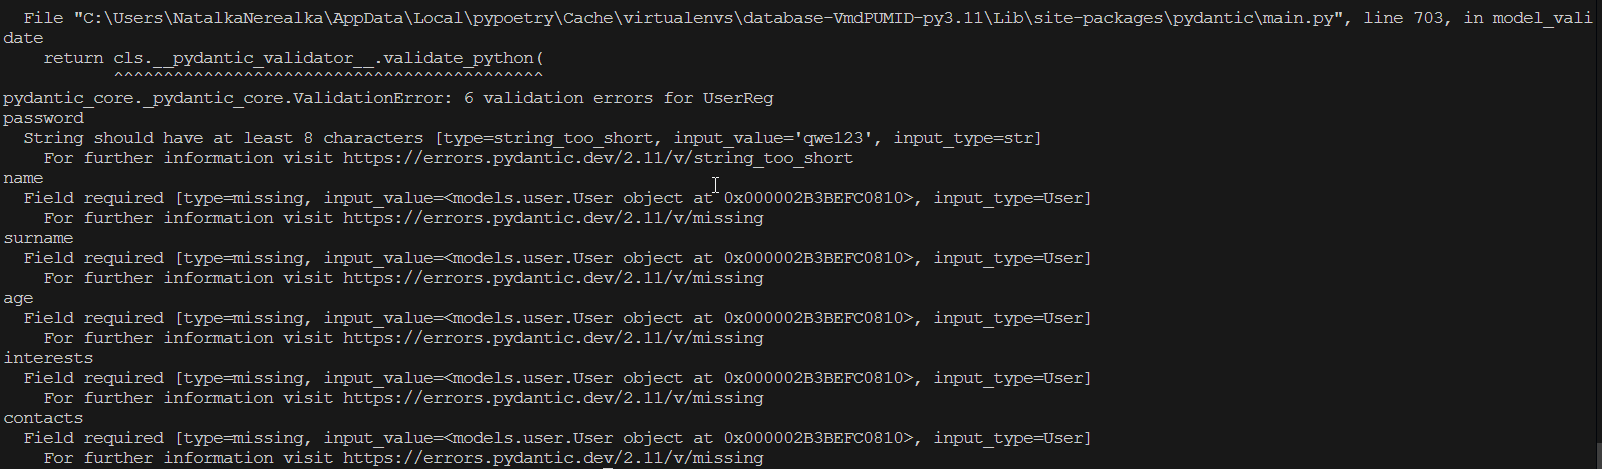

В случае если у проверяемой нашей модели базы данных есть какая либо ошибка в описании мы её увидим. Текущая проблема по большей мере связана с тем что мы в default значениях выставили не совсем верное значение, если у нас поле может пустым, то мы всегда как default ставим None чтобы избежать проблем с валидацией

Исправим ранее описанию модель:

In [ ]:
class UserReg(BaseModel):
    username: str = Field(
        default=...,
        min_length=3,
        max_length=32,
        description="Имя пользователя, на латинице с использованием цифр",
    )
    password: str = Field(
        default=...,
        min_length=8,
        description="Пароль пользователя, включает обязательно латиницу, хотя одну цифру и знак пунктуации",
    )
    email: EmailStr = Field(default=..., description="Электронная почта пользователя")
    phone: str | None = Field(
        default=..., description="Номер телефона пользователя (Опционально)"
    )

    name: str | None = Field(default=None)
    surname: str | None = Field(None)
    age: int | None = Field(
        default=None,
        ge=0,
        le=100,
        description="Возраст пользователя, может быть от 0 до 100",
    )
    gender: GenderEnum = Field(
        default=GenderEnum.UNDEFINED, description="Пол пользователя"
    )
    interests: list | None = Field(None)
    contacts: dict | None = Field(None)

    @field_validator("phone")
    @classmethod
    def validate_phone(cls, value: str | None) -> str:
        if not value:
            return value

        value = (
            value.replace(" ", "").replace("(", "").replace(")", "").replace("-", "")
        )
        print(value)
        if not re.match(r"^\+?\d{1,15}$", value):
            raise ValueError(
                'Номер телефона должен начинаться с "+" и содержать от 1 до 15 цифр'
            )
        return value

    model_config = ConfigDict(from_attributes=True, use_enum_values=True)

Также мы можем заметить что валидация для номера тоже претерпела некоторые изменения и теперь помимо проверки, также происходит и изменение самого номера (убираются пробел а также символы ()-), и в мэтче мы сделали так что + необязателен для номера (для тех кто пишет с 8 а не +7)

# Использование готовых пресет-типов Pydantic

Для дополнительной информации: https://docs.pydantic.dev/latest/api/pydantic_extra_types_phone_numbers/ (оф. док.)

In [ ]:
from typing import Annotated, Union

from pydantic_extra_types.phone_numbers import PhoneNumber, PhoneNumberValidator


class UserRegV2(BaseModel):
    username: str = Field(
        default=...,
        min_length=3,
        max_length=32,
        description="Имя пользователя, на латинице с использованием цифр",
    )
    password: str = Field(
        default=...,
        min_length=8,
        description="Пароль пользователя, включает обязательно латиницу, хотя одну цифру и знак пунктуации",
    )
    email: EmailStr = Field(default=..., description="Электронная почта пользователя")
    
    phone: Annotated[
        Union[str, PhoneNumber],
        PhoneNumberValidator(),
    ]

    name: str | None = Field(default=None)
    surname: str | None = Field(None)
    age: int | None = Field(
        default=None,
        ge=0,
        le=100,
        description="Возраст пользователя, может быть от 0 до 100",
    )
    gender: GenderEnum = Field(
        default=GenderEnum.UNDEFINED, description="Пол пользователя"
    )
    interests: list | None = Field(None)
    contacts: dict | None = Field(None)
